<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_5_1__Neural_Networks_Basics_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Basics 1
## (Dive into Deep Learning https://d2l.ai/chapter_linear-networks/index.html)

* The material for this notebook is mainly from the Open Source book -- Dive into Deep Learning. I have adapted a few things for the Computer Vision course at the University of South Florida, Tampa.

* Some figures are from Richard Szeliski's vision textbook for this course.

# Topics covered

* You will get introduced to the essential components that go into constructing and training neural networks

* You will be introduced to the linear regression problem and how it can be solved using stochastic gradient descent.

* You will learn how to construct the most straightforward classification neural network using softmax operation (activation function). You will also learn about the cross-entropy loss function

**Concepts Learned:** linear regression, model, train, mini-batches, *stochastic* gradient search, epochs, hyperparamters, softmax, activation function, cross-entropy loss function, squared loss function, fully connected layer, classification accuracy, python data iterator.

## Code: setup

In [1]:
!pip install d2l==0.16.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F


# Linear Regression

* *Regression* refers to a set of methods for modeling the relationship between one or more **independent** variables and a **dependent** variable or the **predicted** variable.

* Examples: local images features (e.g., color values) to label objects in images;  video to label action type;  face image to label emotions


* We will implement the entire method from scratch, including

    1. the data pipeline,
    2. the model,
    3. the loss function, and
    4. the minibatch stochastic gradient descent optimizer.

* For now, we will rely only on tensors and auto differentiation. Afterward, we will introduce a more straightforward implementation, taking advantage of the bells and whistles of deep learning frameworks.


## Generating the Dataset

* We construct an artificial dataset according to a linear model with additive noise.

* Our task will be to recover this model's parameters using the finite set of examples in our dataset.

* In the following code snippet, we generate a dataset, $\mathbf{X}$, containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution. Thus our synthetic dataset will be a $1000 \times 2$ matrix.

* This input data is transformed linearly using

\begin{equation}
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon
\end{equation}

* $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and $\epsilon$ captures potential measurement errors on the features and labels.

* We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with a mean of 0.
    * To make our problem easy, we will set its standard deviation to 0.01.


###Code: `generate_synthetic_data`

In [4]:
def generate_synthetic_data (w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = generate_synthetic_data (true_w, true_b, 1000)

In [5]:
features.size()

torch.Size([1000, 2])

* **Note that each row in `features` consists of a 2-dimensional data example and that each row in `labels` consists of a 1-dimensional label value (a scalar).**


In [6]:
print('First 10 features:\n', features[1:10,:], '\nFirst 10 labels:\n', labels[1:10])

First 10 features:
 tensor([[ 1.2221,  0.5372],
        [ 1.4228,  0.4576],
        [-0.6984, -0.5055],
        [ 0.2280,  0.6175],
        [ 1.7191, -0.7174],
        [-1.6621,  0.5776],
        [ 1.5501,  0.3772],
        [-0.0956,  0.1393],
        [-0.9308, -0.6321]]) 
First 10 labels:
 tensor([[ 4.8310],
        [ 5.5026],
        [ 4.5068],
        [ 2.5506],
        [10.0801],
        [-1.0856],
        [ 6.0176],
        [ 3.5284],
        [ 4.4928]])


* **Observe the linear correlation between the input and the output.**


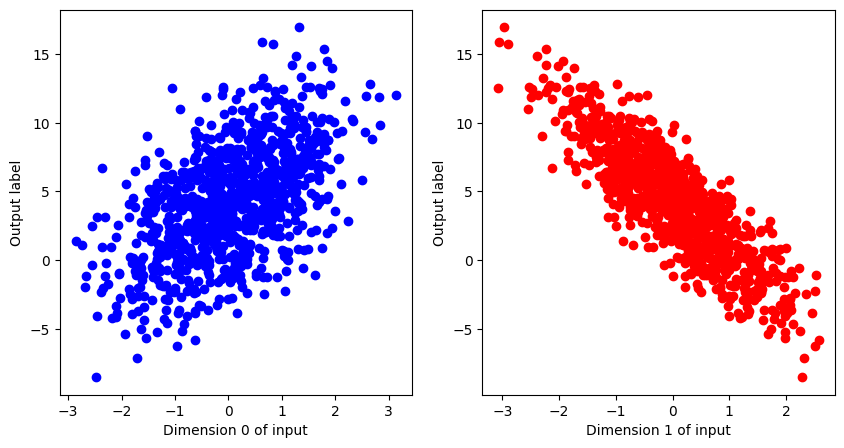

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches (10, 5)

ax[0].scatter(features[:, 0].detach().numpy(),
                labels.detach().numpy(), c='b')
ax[0].set_xlabel('Dimension 0 of input')
ax[0].set_ylabel('Output label')

ax[1].scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), c='r')
ax[1].set_xlabel('Dimension 1 of input')
ax[1].set_ylabel('Output label');

## Reading the Dataset

* Estimating the linear model parameters from the training data involve iterations over the dataset.

* Recall how **gradient descent** or Newton's method (with Hessian) worked for 2D perspective transformation (homography) estimation.

    * At each iteration, we computed a gradient value based on the **entire** dataset.

* Here, we adopt **stochastic** gradient descent, which works well in practice.

    * Instead of considering the entire dataset at each iteration, we
form many subsets of the data and use the subsets to update our model, one at a time.

* We break the dataset into **mini-batches**, each consisting of **batch size** number of data samples. Each minibatch consists of a tuple of input features and labels.

    * At each iteration, we compute the gradient based on one minibatch at a time.

    * Updates from the different subsets of the data are randomly varying, which gives its name *stochastic*.

    *  Minibatches sizes depend on available GPU hardware. We can also compute the gradient of the loss function for each example in parallel; GPUs allow us to process hundreds of inputs in scarcely more time than it might take to process just a single sample.

* Since this process is so fundamental to training machine learning algorithms,
it is worth defining a utility function to shuffle the dataset and access it in mini-batches.

    * In the following code, we define the **`data_iter` function** to demonstrate one possible implementation of this functionality. The function takes a **batch size, a matrix of features, and a vector of labels, yielding mini-batches of the size `batch_size.`**


### Code: Some python background about iterators, generators

* An iterator in Python is an object that contains a finite number of elements that can be iterated upon, i.e. go through the ordered collection  one element at a time.

* A generator is a special type of function which returns an iterator object.  *It can be run only once*.

In [8]:
'''
Some python background about iterators, generators, and yield that we will use.
Example taken from https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
'''
mylist = [1, 2, 3]
for i in mylist:
    print(i)

1
2
3


In [9]:
# --------Iterator object--------------------
# An iterator in Python is an object that contains a finite number of
# elements that can be iterated upon, i.e. go through the ordered collection
# one element at a time.

print('Iterator output (first run):')
mylist = [x*x for x in range(3)]
for i in mylist:
    print(i)

print('Iterator output (second run):')
for i in mylist:
    print(i)


Iterator output (first run):
0
1
4
Iterator output (second run):
0
1
4


In [10]:
# ---------Generator object--------------------
# A generator is a special type of function which returns an iterator object.
# Can be run only once.

mygenerator = (x*x for x in range(3))
"note the use of parenthesis instead of brackets"
print('Mygenerator created using yield is:', mygenerator) # mygenerator is an object!

print('Generator output (first run):')
for i in mygenerator:
    print(i)

print('Generator output (second run):')
for i in mygenerator:
    print(i)

Mygenerator created using yield is: <generator object <genexpr> at 0x78189e342c00>
Generator output (first run):
0
1
4
Generator output (second run):


In [11]:
#-----------Yield returns generator object--------
# In a generator function, a "yield" statement is used rather than a "return" statement.
# You use generators to create your own iterators.
# Can be run only once.

def create_generator():
    mylist = range(3)
    for i in mylist:
        yield i*i

mygenerator = create_generator() # create a generator
print('Mygenerator created using yield is:', mygenerator) # mygenerator is an object!
for i in mygenerator:
    print(i)

print('Mygenerator created using yield is (second run):', mygenerator) # mygenerator is an object!
for i in mygenerator:
    print(i)


Mygenerator created using yield is: <generator object create_generator at 0x78189bdc77d0>
0
1
4
Mygenerator created using yield is (second run): <generator object create_generator at 0x78189bdc77d0>


### Code: `data_iter` over randomized minibatches

In [12]:
import numpy as np

# Generator function over the data
def data_iter (batch_size, features, labels):
    num_examples = features.shape[0]
    # We randomly shuffle the data in the beginning so breakup any bias induced due to order of data
    indices = np.random.permutation (num_examples)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
" notice yield above"

' notice yield above'

* To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.


* As we run the iteration, we obtain distinct mini-batches
successively until the entire dataset has been exhausted (try this).


* This method works but is inefficient, requiring that we load all the data in memory and perform lots of random memory access. **The built-in iterators implemented in a deep learning framework are considerably more efficient and can deal with data stored in files and data fed via data streams.** We will get introduced to them later.



In [13]:
batch_size = 11
# print first batch and then exit.
i = 1
for X, y in data_iter(batch_size, features, labels):
    print(i, X.size())
    i = i+1


1 torch.Size([11, 2])
2 torch.Size([11, 2])
3 torch.Size([11, 2])
4 torch.Size([11, 2])
5 torch.Size([11, 2])
6 torch.Size([11, 2])
7 torch.Size([11, 2])
8 torch.Size([11, 2])
9 torch.Size([11, 2])
10 torch.Size([11, 2])
11 torch.Size([11, 2])
12 torch.Size([11, 2])
13 torch.Size([11, 2])
14 torch.Size([11, 2])
15 torch.Size([11, 2])
16 torch.Size([11, 2])
17 torch.Size([11, 2])
18 torch.Size([11, 2])
19 torch.Size([11, 2])
20 torch.Size([11, 2])
21 torch.Size([11, 2])
22 torch.Size([11, 2])
23 torch.Size([11, 2])
24 torch.Size([11, 2])
25 torch.Size([11, 2])
26 torch.Size([11, 2])
27 torch.Size([11, 2])
28 torch.Size([11, 2])
29 torch.Size([11, 2])
30 torch.Size([11, 2])
31 torch.Size([11, 2])
32 torch.Size([11, 2])
33 torch.Size([11, 2])
34 torch.Size([11, 2])
35 torch.Size([11, 2])
36 torch.Size([11, 2])
37 torch.Size([11, 2])
38 torch.Size([11, 2])
39 torch.Size([11, 2])
40 torch.Size([11, 2])
41 torch.Size([11, 2])
42 torch.Size([11, 2])
43 torch.Size([11, 2])
44 torch.Size([11, 2

## Initializing model parameters

**Before we can begin optimizing our model's parameters** by minibatch stochastic gradient descent, (**we need to have some parameters in the first place.**). In the following code, we initialize weights by sampling random numbers from a normal distribution with a mean of 0 and a standard deviation of 0.01 and setting the bias to 0.


### Code: Initialize parameters (`w, b`)

In [14]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print('weights:\n', w, '\nb=\n', b)

weights:
 tensor([[ 0.0086],
        [-0.0072]], requires_grad=True) 
b=
 tensor([0.], requires_grad=True)


* After initializing our parameters, our next task is to update them until they fit our data sufficiently well.

* Each update requires taking the gradient of our loss function with respect to the parameters.

* To compute gradients explicitly, we use automatic differentiation to compute the gradient.


## Defining the Model

* Next, we must **define our model, relating its inputs and parameters to its outputs.**

* To calculate the output of the linear model, we take the matrix-vector dot product of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$, and add the offset $b$ to each example.

* The product $\mathbf{Xw}$  is a vector, and $b$ is a scalar.
    * We will use the *broadcasting* feature to add the scalar.


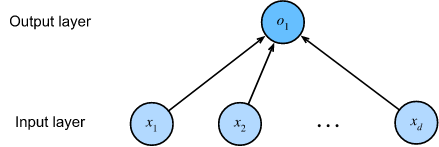

### Code: `linreg`: The linear regression model

In [15]:
def linreg(X, w, b):
    """The linear regression model."""
    # X is N by d, where N is the number of data elements, d is the dimension of the data
    # w is a d by 1 vector of parameters
    return torch.matmul(X, w) + b

## Defining the Loss Function

* Since updating our model requires taking the gradient of our loss function, we ought to (**define the loss function next**)

* We will use the **squared loss** function (**squared residuals**)

* Note that we do **not** sum the residuals yet. The function returns the residuals for **each** data point of the input.

* Some python implementation issue: although both `y` and `y_hat` are just a vector of numbers, they might be represented as 1D ($[n]$ sized) or as 2D ($[n,1]$ sized) arrays. We have to reshape one to fit the other.

* The result returned by the following function will also have the same shape as `y_hat`.



### Code: `squared_loss` function

In [16]:
def squared_loss(y_hat, y):
    """Squared loss."""
    # although both y and y_hat are just a vector of numbers,
    # they might be represented as [n] or as [n,1] arrays.
    # that is what we have to reshape one to fit the other.
    # Another option would have been to squeeze out the "1" dimension
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Stochastic gradient descent -- the optimization algorithm

* For each minibatch of `batch_size`,

    1. Estimate the gradient of the loss with respect to our parameters.
    2. Update the parameters (`params`) in the direction that may reduce the loss based on a learning rate (`lr`). Because we calculate our loss as a sum over the minibatch of examples, we normalize our step size by the batch size (`batch_size`), so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.

###Code: `stochastic_gradient_descent` function

In [17]:
def stochastic_gradient_descent (params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

* Now that we have all the parts in place, we are ready **to implement the main training loop**.

* It is crucial that you understand this code because you will see nearly identical training loops repeatedly throughout your career in deep learning.

* Initialize parameters $(\mathbf{w}, b)$
* At each iteration over the mini-batches of the *entire* dataset
    1. We will grab a minibatch of training examples,
    2. Pass minibatch through the model to obtain a set of predictions.
    3. Calculate the loss,
    3. Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
        * Initiate the backward pass through the network, computing and storing the gradients with respect to each parameter.
    5. Call `stochastic_gradient_descent` to update the model parameters.
        * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

* Each pass (using the `data_iter` function) through the dataset is called one **epoch**. To optimize, we need **multiple epochs**

* The number of epochs `num_epochs` and the learning rate `lr` are both **hyperparameters**, which we set here to 3 and 0.03, respectively.

* Unfortunately, setting hyperparameters is tricky.
Moreover, it requires some adjustment by trial and error.


###Code: Training

In [18]:
lr = 0.03 # learning rate
num_epochs = 10 # number of passes through the entire dataset
batch_size = 10
net = linreg
loss = squared_loss
print('Initial w=\n', w, '\nInitial b=\n', b)
print('True w=\n', true_w, '\nTrue b=\n', true_b)


Initial w=
 tensor([[ 0.0086],
        [-0.0072]], requires_grad=True) 
Initial b=
 tensor([0.], requires_grad=True)
True w=
 tensor([ 2.0000, -3.4000]) 
True b=
 4.2


In [19]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]

        l.sum().backward()

        stochastic_gradient_descent([w, b], lr, batch_size)  # Update parameters using their gradient

    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        #print('\nw=\n', w, '\nb=\n', b)
        print(f'epoch {epoch + 1}, w= {w.numpy().transpose()}, b= {b.numpy()}, loss {float(train_l.mean()):f}',)


epoch 1, w= [[ 1.9586987 -3.242708 ]], b= [4.0188565], loss 0.030404
epoch 2, w= [[ 2.0002077 -3.3929346]], b= [4.1918755], loss 0.000110
epoch 3, w= [[ 2.0006409 -3.4000928]], b= [4.199799], loss 0.000049
epoch 4, w= [[ 2.0002313 -3.4003437]], b= [4.199756], loss 0.000048
epoch 5, w= [[ 2.0003974 -3.4005167]], b= [4.2002077], loss 0.000048
epoch 6, w= [[ 2.0004327 -3.4002538]], b= [4.1999335], loss 0.000048
epoch 7, w= [[ 2.0003245 -3.4005017]], b= [4.199876], loss 0.000048
epoch 8, w= [[ 2.0003724 -3.4001908]], b= [4.1999693], loss 0.000048
epoch 9, w= [[ 2.0004184 -3.4002445]], b= [4.199811], loss 0.000048
epoch 10, w= [[ 2.0000982 -3.4003506]], b= [4.1999736], loss 0.000048


In this case, because we synthesized the dataset ourselves, we precisely know the true parameters. Thus, we can **evaluate our success in training by comparing the true parameters with those that we learned** through our training loop. Indeed they turn out to be very close to each other.


In [20]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-9.8228e-05,  3.5048e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([2.6226e-05], grad_fn=<RsubBackward1>)


* Note that we should not take it for granted that we can recover the parameters perfectly. However, in machine learning, we are typically less concerned with recovering true underlying parameters and more concerned with parameters that lead to highly accurate predictions. Fortunately, even on complex optimization problems, stochastic gradient descent can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to highly accurate predictions.


## Summary

* We saw how a deep network could be implemented and optimized from scratch, using just tensors and auto differentiation.

* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts we have just introduced and learn how to implement them more concisely.


# Assignment

1. Why is the `reshape` function needed in the `squared_loss` function? Try removing the `reshape` function and see.
2. What would happen if we were to initialize the weights to zero. Would the algorithm still work? Report the results with zero-initialization and compare with random.
3. Experiment with 3 different learning rates to find out how fast the loss function value drops.
4. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?

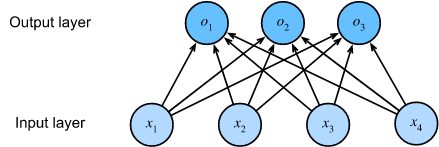

# Fully connected, single-layer, softmax network for classification

* Consider the **classification problem**: given the feature of dimension  $d$, we have to label each data item with one of 3 labels.
    * For example, given a $N \times N$ image, i.e. input dimension $d = N^2$, figure out the state of the light, red, green, or orange.

* The output layer has multiple outputs, one per class.

* Each output is connected to all the inputs. Hence, we have a **fully connected layer**.

\begin{eqnarray}
o_1 &= & x_1 w_{11} + \cdots + x_d w_{1d} + b_1\\
o_2 &= & x_1 w_{21} + \cdots + x_d w_{2d} + b_2\\
\vdots & = &  \vdots \\
o_k &= & x_1 w_{k1} + \cdots + x_d w_{kd} + b_k
\end{eqnarray}


* More compactly, we can use linear algebra notation.

\begin{equation}
\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}
\end{equation}

>* A matrix-vector product of the weights by the input features plus our **biases** $\mathbf{b}$ results in the output.
>* What is the total number of unknown parameters for a fully connected layer with an input of dimension $d$ and $k$ outputs?
>* Also referred to as **logits**

* Note that is an **affine transformation** of the inputs.

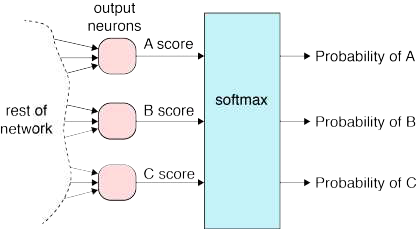

## Softmax operation

* Nothing constrains the output from summing to 1. The outputs can take on negative values too.

* We would like each output to be a probability, i.e., a number between 0 and 1, that denotes the probability of the corresponding label for any given input.
Ideally, only one of the outputs will be near 1, and the rest will be near 0.

* We need to transform this output layer into a final output that is guaranteed (even on new data) to be nonnegative and sum to 1.

* We also need a loss function that encourages the model to estimate probabilities faithfully. Of all instances when a classifier outputs 0.5, we hope that half of those examples will belong to the predicted class.
This is a property called **calibration**.

* The **softmax function**, invented in 1959 by the social scientist R. Duncan Luce in the context of *choice models*, does precisely this.

\begin{equation}
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{where}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}
\end{equation}

* It is easy to see $\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$
with $0 \leq \hat{y}_j \leq 1$ for all $j$.
Thus, $\hat{\mathbf{y}}$ behaves like a probabilities.

* Note that the softmax operation does not change the ordering among the logits $\mathbf{o}$,
which are simply the pre-softmax values
that determine the probabilities assigned to each class.
Therefore, during prediction, we can still pick out the most likely class by

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

* Although softmax is a nonlinear function, the outputs of softmax regression are still *determined* by an affine transformation of input features;


## Vectorization for mini-batch

* To improve computational efficiency and take advantage of GPUs, we typically carry out vector calculations for mini-batches of data.

* Let  $\mathbf{X}$ be $n \times d$ matrix representing a minibatch of examples with feature dimensionality (number of inputs) $d$ and batch size $n$.

* Then, weights $\mathbf{W}$ is a ${d \times q}$ matrix
and the bias is a ${1\times q}$ vector $\mathbf{b}$.

* The fully connected layer with softmax can compute outputs for **all** inputs in a minibatch **simultaneously** using matrix multiply. No for-loops needed.

\begin{equation}
\begin{aligned} \mathbf{O}^{n \times q} &= \mathbf{X}^{n \times d} \mathbf{W}^{d \times q} + \mathbf{b}^{1\times q}, \\
\hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}
\end{equation}

* [Broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) is triggered during the summation $\mathbf{X} \mathbf{W} + \mathbf{b}$, both the minibatch $\mathbf{O}$ and output probabilities $\hat{\mathbf{Y}}$ are $n \times q$ matrices.



## Loss Function -- Cross entropy


* Squared difference error is not the appropriate error/residual/loss function to optimize. We use an error function that is appropriate for probability distributions -- **cross-entropy**.

* The softmax function gives us a vector $\hat{\mathbf{y}}$, which we can interpret as estimated probabilities of each class given any input $\mathbf{x}$, e.g., $\hat{y}_1$ = $P(y=\text{cat} \mid \mathbf{x})$.

* Suppose that the entire dataset $\{\mathbf{X}, \mathbf{Y}\}$ has $n$ examples,
where the example indexed by $i$ consists of a feature vector $\mathbf{x}^{(i)}$ and a **one-hot label vector** $\mathbf{y}^{(i)}$, i.e., an all-zero vector with one entry equal to 1 corresponding to the position denoting the label.

* We can compare the estimates with labels by checking how probable the actual classes are according to our model, given the features:

\begin{equation}
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
\end{equation}

* According to maximum likelihood estimation,
we maximize $P(\mathbf{Y} \mid \mathbf{X})$,
which is
equivalent to minimizing the negative log-likelihood:

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

> where for any pair of label $\mathbf{y}$ and model prediction $\hat{\mathbf{y}}$ over $q$ classes,
the loss function $l$ is

\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}


* This loss function is commonly called the **cross-entropy loss**.

* $\mathbf{y}$ is a **one-hot vector** of length $q$
    * so, the sum over all its coordinates $j$ vanishes for all but one term.

* Since all $\hat{y}_j$ are predicted probabilities, their logarithm is never larger than $0$.

* Consequently, the loss function cannot be minimized any further
if we correctly predict the actual label with *certainty*,
i.e., if the predicted probability $P(\mathbf{y} \mid \mathbf{x}) = 1$ for the actual label $\mathbf{y}$.


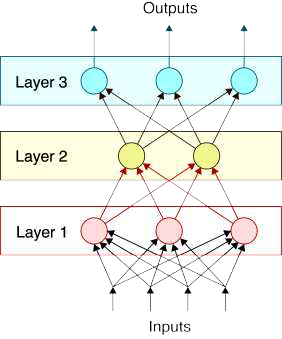

## Summary of Model

* Let  $\mathbf{X}$ be $n \times d$ matrix representing a minibatch of examples with feature dimensionality (number of inputs) $d$ and batch size $n$.

* Then, weights $\mathbf{W}$ is a ${d \times q}$ matrix
and the bias is a ${1\times q}$ vector $\mathbf{b}$.

* The fully connected layer with softmax can compute outputs for **all** inputs in a minibatch **simultaneously** using matrix multiply. No for-loops needed.

\begin{equation}
\begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}
\end{equation}

* This loss function is commonly called the **cross-entropy loss**.


\begin{equation}
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j
\end{equation}


## Implementation of softmax regression

* Just as we implemented linear regression from scratch, we believe that softmax regression is similarly fundamental, and you ought to know the gory details of softmax regression and how to implement it yourself.

* We will work with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), setting up a data iterator with batch size 256.


###Code: ReadFashion MSNIST data (`train_iter, test_iter`)

In [21]:
import torch
from IPython import display
from d2l import torch as d2l

In [22]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

for X, y in train_iter:
    print('Each element of train_iter has: X=',  X.shape, 'y=', y.shape)
    break

for X, y in test_iter:
    print('Each element of test_iter  has: X=', X.shape, 'y=', y.shape)

    print(' We will reshape X before use into =', X.reshape((-1, 784)).shape)
    break


100%|██████████| 26421880/26421880 [00:00<00:00, 110604059.99it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5924050.46it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 65461181.02it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5630319.95it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Each element of train_iter has: X= torch.Size([256, 1, 28, 28]) y= torch.Size([256])
Each element of test_iter  has: X= torch.Size([256, 1, 28, 28]) y= torch.Size([256])
 We will reshape X before use into = torch.Size([256, 784])


## Defining the fully connected (FC) layer

* As in our linear regression example, each example here will be represented by a fixed-length vector. Each example in the raw dataset is a $28 \times 28$ image. In this section, **we will flatten each image, treating them as vectors of length 784.** In the future, we will talk about more sophisticated strategies for exploiting the spatial structure in images, but for now, we treat each pixel location as just another feature.

* Recall that in softmax regression, we have as many outputs as there are classes. **Because our dataset has 10 classes, our network will have an output dimension of 10.** Consequently, our weights will constitute a $784 \times 10$ matrix and the biases will constitute a $1 \times 10$ row vector. As with linear regression, we will initialize our weights `W` with Gaussian noise and our biases to take the initial value 0.


### Code: Fully connected (FC) layer (`W, b`)

In [23]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

print('W shape is', W.shape, '\nW=', W)
print('\nb shape is', b.shape, '\nb=', b)

W shape is torch.Size([784, 10]) 
W= tensor([[ 0.0142,  0.0061,  0.0040,  ..., -0.0048, -0.0061, -0.0059],
        [-0.0120,  0.0036, -0.0058,  ..., -0.0127,  0.0062,  0.0005],
        [ 0.0032,  0.0016,  0.0045,  ..., -0.0012, -0.0083, -0.0050],
        ...,
        [-0.0231,  0.0144,  0.0002,  ..., -0.0095, -0.0113, -0.0113],
        [ 0.0088, -0.0180,  0.0105,  ..., -0.0032, -0.0049,  0.0055],
        [ 0.0162, -0.0069, -0.0055,  ..., -0.0003, -0.0231, -0.0063]],
       requires_grad=True)

b shape is torch.Size([10]) 
b= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


## Defining the softmax operation

* Before implementing the softmax regression model, let us briefly review how the sum operator works along specific dimensions in a tensor. **Given a matrix `X`, we can sum over all elements (by default) or only over elements in the same axis,**, i.e., the same column (axis 0) or the same row (axis 1).

* When invoking the sum operator, we can specify to keep the number of axes in the original tensor rather than collapsing out the dimension that we summed over. The result is a two-dimensional tensor with shape (1, 3).

* Note that if `X` is a tensor with shape (2, 3) and we sum over the columns, the result will be a vector with shape (3,).


In [24]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print('X, sum over dim 0\n', X.sum(0, keepdim=False))
print('\nX, sum over dim 1\n', X.sum(0, keepdim=True))

X, sum over dim 0
 tensor([5., 7., 9.])

X, sum over dim 1
 tensor([[5., 7., 9.]])


* We are now ready to **implement the softmax operation**. Recall that softmax consists of three steps:
    1. We exponentiate each term (using `exp`)
    2. we sum over each row (we have one row per example in the batch) to get the normalization constant for each example
    3. We divide each row by its normalization constant, ensuring that the result sums it to 1.

* Before looking at the code, let us recall how this looks expressed as an equation. We are processing one minibatch at a time, so $\mathbf{O}_{ij}$ is `batch_size` $\times$ `output_dim` matrix, whose rows store the output vector for the corresponding training sample in the minibatch.

\begin{equation}
\mathrm{softmax}(\mathbf{O})_{ij} = \frac{\exp(\mathbf{O}_{ij})}{\sum_k \exp(\mathbf{O}_{ik})}
\end{equation}

* (Advanced Material:) The denominator, or normalization constant, is sometimes called the **partition function** (its logarithm is called the log-partition function). The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics)), where a related equation models the distribution over an ensemble of particles.


### Code: Softmax layer (`softmax`)

In [25]:
def softmax(Oh):
    Oh_exp = torch.exp(Oh)
    partition = Oh_exp.sum(1, keepdim=True)
    return Oh_exp / partition  # The broadcasting mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability measure.


In [26]:
Oh = torch.normal(0, 1, (2, 5))
Y_prob = softmax(Oh)
print('Oh =\n', Oh)
print('Y_prob =\n', Y_prob, '\nSum=', Y_prob.sum(1))

Oh =
 tensor([[ 1.3479,  0.5485, -2.4009,  0.4688,  0.1085],
        [-0.9598, -0.7806,  0.3442, -1.1599, -0.0571]])
Y_prob =
 tensor([[0.4592, 0.2064, 0.0108, 0.1906, 0.1330],
        [0.1091, 0.1305, 0.4020, 0.0893, 0.2691]]) 
Sum= tensor([1., 1.])


## Putting together the Model

Now that we have defined the softmax operation, we can **implement the softmax regression model.** The below code implements how the input is mapped to the output through the network. Note that we flatten each original image in the batch into a vector using the `reshape` function before passing the data through our model.


###Code: Model (`net`)

In [27]:
def net(X):
    # X dimension is [256, 1, 28, 28] which we reshape into [256, 784]
    # size of W is [784 10]
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


## Defining the cross-entropy loss function

* Recall that cross-entropy takes the negative log-likelihood of the predicted probability assigned to the true label. We can pick all elements by a single operator rather than iterating over the predictions with a Python for-loop (which tends to be inefficient).

* Below, we **create sample data `y_hat` with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**

* With `y`, we know that in the first example, the first class is the correct prediction, and in the second example, the third class is the ground truth.
**Using `y` as the indices of the probabilities in `y_hat`,** we pick the probability of the first class in the first example and the probability of the third class in the second example.


In [28]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6],
                      [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Now we can **implement the cross-entropy loss function** efficiently with just one line of code.


### Code: `cross_entropy_loss`

In [30]:
def cross_entropy_loss (y_hat, y):

    return -torch.log(y_hat[range(len(y_hat)), y])
    #range(len(y_hat)) creates indices 0,1,2,len-1

cross_entropy_loss (y_hat, y)


tensor([2.3026, 0.6931])

## Classification Accuracy

* Given the predicted probability distribution `y_hat`, we typically choose the class with the highest predicted probability whenever we must output a hard prediction.

    * Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums". It might estimate probabilities internally, but it has to choose one among the classes at the end of the day.

* The classification accuracy is the fraction of all correct predictions. Although it can be challenging to optimize accuracy directly (it is not differentiable), it is often the performance measure we care most about, and we will nearly always report it when training classifiers.

* To compute accuracy, we do the following.
    1. If `y_hat` is a matrix, we assume that the second dimension stores prediction scores for each class. We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
    2. We **compare the predicted class with the ground-truth `y` elementwise.** Since the equality operator `==` is sensitive to data types, we convert `y_hat`'s data type to match that of `y`. The result is a tensor containing 0 (false) and 1 (true) entries. Taking the sum yields the number of correct predictions.


In [31]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #The output is a vector -- not just a scalar
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

We will continue to use the variables `y_hat` and `y`
defined before
as the predicted probability distributions and labels, respectively.
We can see that the first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.
The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.


In [32]:
accuracy(y_hat, y) / len(y)

0.5

**Similarly, we can evaluate the accuracy for any model `net` on a dataset** that is accessed via the data iterator `data_iter`.


###Code: `evaluate_accuracy`

In [33]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter: # iterate over the minibatches
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

* Here `Accumulator` is a utility class to accumulate sums over multiple variables.

* In the above `evaluate_accuracy` function, we create 2 variables in the `Accumulator` instance to store the number of correct predictions and the number of predictions, respectively.

* We  will accumulate both over time as we iterate over the dataset.


In [34]:
[0.0] * 4

[0.0, 0.0, 0.0, 0.0]

In [35]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # creates [0.0, 0.0, ....n-times]

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # Example: let self.data = [10, 15] and args be [3, 4]
        # zip(self.data, args) will produce the paired iterable [(10, 3), (15, 4)]
        # the for loop with go over these paired entries adding them up to result in [13, 19]

    def reset(self):
        self.data = [0.0] * len(self.data) # creates [0.0, 0.0, ....n-times]

    def __getitem__(self, idx):
        return self.data[idx]

**Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing,** i.e., 0.1 for 10 classes.


In [36]:
evaluate_accuracy(net, test_iter)

0.078

## Training

* The training loop for softmax regression should look strikingly familiar to the implementation of linear regression.

* Here, we refactor the implementation to make it reusable. First, we define a function to train for one epoch. Note that `updater` is a general function to update the model parameters, which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function or a framework's built-in optimization function.


### Code: `train_one_epoch`

In [37]:
def my_updater (batch_size):
    return stochastic_gradient_descent([W, b], lr, batch_size)

# we use the minibatch stochastic gradient descent we wrote earlier to
# optimize the loss function of the model

In [38]:
def train_one_epoch (net, train_iter, loss, updater):

    metric = Accumulator(3) # Sum of training loss, sum of training accuracy, no. of examples
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        l.sum().backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function,
we define **a utility class that plot data in animation.**

###Code: `Animator` class

In [39]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

* The following function trains a model `net` on a training dataset accessed via `train_iter` for multiple epochs, which is specified by `num_epochs`.

* At the end of each epoch, the model is evaluated on a test dataset accessed via `test_iter`.

* We will leverage the `Animator` class to visualize the training progress.


###Code: `train_full`

In [40]:
def train_full (net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_one_epoch (net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return (train_loss, train_acc, test_acc)

Now we **train the model with 10 epochs.** Note that both the number of epochs (`num_epochs`), and learning rate (`lr`) are adjustable hyperparameters. By changing their values, we may be able to increase the classification accuracy of the model.


### Code: Run train

(0.447199605178833, 0.8479333333333333, 0.8327)

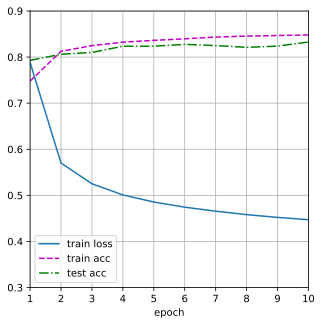

In [41]:
num_epochs = 10
lr = 0.1
train_full (net, train_iter, test_iter, cross_entropy_loss, num_epochs, my_updater)

## Prediction

Now that training is complete, our model is ready to **classify some images.**
Given a series of images, we will compare their actual labels (first line of text output) and the predictions from the model (second line of text output).


### Code: `predict`

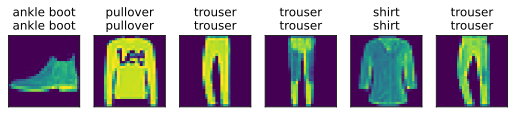

In [42]:
def predict (net, test_iter, n=6):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1)) ## This is how you invoke the model
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict (net, test_iter)

## Summary

* With softmax regression, we can train models for multiclass classification.
* The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.



# Assignment

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause? Hint: Try calculating the size of $\exp(50)$.
1. The function `cross_entropy` in this section was implemented according to the definition of the cross-entropy loss function. What could be the problem with this implementation? Hint: consider the domain of the logarithm.
1. What solutions can you consider to fix the two problems above?
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
